Regressão Logística para Previsão de Inadimplência Futura
1. Objetivo do Modelo para a Persona de Negócios
Persona: Síndico, Administradora do Condomínio, Conselho Fiscal.

Objetivo: O modelo de Regressão Logística visa prever, para cada unidade, a probabilidade de ela não realizar o pagamento da sua cota condominial no próximo mês.

Benefício para a Persona: Com essa previsão, o síndico e a administradora podem antecipar ações preventivas. Isso inclui enviar lembretes personalizados, iniciar contatos para negociação antes do atraso se consolidar ou até mesmo priorizar unidades para acompanhamento mais próximo. O objetivo final é reduzir o índice de inadimplência e melhorar o fluxo de caixa do condomínio, evitando surpresas financeiras e a necessidade de rateios extras. A simplicidade e interpretabilidade da Regressão Logística a tornam adequada para explicar os resultados à gestão.

Para tornar o dataset mais completo do que na fase anterior, vamos acrescentar as colunas nome, idade, residentes(numero de pessoas no apartamento) e renda estimada. Todas associadas ao  unidade_id com valores aproximados a realidade, mas preservando com nomes totalmente fictícios.

In [ ]:
import pandas as pd
import numpy as np
from faker import Faker # Gerar nomes e dados fictícios

predio = pd.read_csv('condominio_atualizado.csv')

unique_units_info = predio[['unidade_id', 'tipo_unidade', 'metragem', 'media_pagamento_unidade']].drop_duplicates()

fake = Faker('pt_BR')
np.random.seed(42) 

unit_new_data = {}

for index, row in unique_units_info.iterrows():
    unit_id = row['unidade_id']
    tipo_unidade = row['tipo_unidade']
    metragem = row['metragem']
    media_pagamento = row['media_pagamento_unidade']

    ###  NOME (Proprietário) 
    nome_proprietario = fake.name() 

    ### IDADE (Proprietário) 
    idade_proprietario = np.random.randint(20, 80) # Idade entre 20 e 80 anos

    ### RESIDENTES 
    num_residentes = 0
    if tipo_unidade == 'apartamento':
        base_res = np.random.randint(1, 3) # 1 ou 2 residentes base
        var_res_metragem = (metragem / 50) * np.random.rand() # Variação ligada à metragem
        num_residentes = int(base_res + var_res_metragem)
        num_residentes = max(1, min(num_residentes, 5)) # Mínimo 1, máximo 5
    else: ### Lojas
        num_residentes = np.random.randint(0, 2) # 0 ou 1 (ex: dono ou funcionário)

    ### RENDA_APROXIMADA 
    renda_aproximada = 0.0
    if tipo_unidade == 'apartamento':
        base_renda = np.random.lognormal(mean=np.log(5000), sigma=0.8) # Renda base para apartamentos
        ajuste_pagamento = (media_pagamento - 0.5) * 0.5 
        renda_aproximada = base_renda * (1 + ajuste_pagamento + (np.random.rand()-0.5)*0.2)
        renda_aproximada = max(1500.0, round(renda_aproximada, 2)) # Renda mínima de R$1500

    else: ### Lojas
        base_renda = np.random.lognormal(mean=np.log(15000), sigma=1.2) # Renda base para lojas
        ajuste_pagamento = (media_pagamento - 0.5) * 0.2
        renda_aproximada = base_renda * (1 + ajuste_pagamento + (np.random.rand()-0.5)*0.1)
        renda_aproximada = max(3000.0, round(renda_aproximada, 2)) # Renda mínima de R$3000

    ### Armazenar os dados para esta unidade
    unit_new_data[unit_id] = {
        'NOME': nome_proprietario,
        'IDADE': idade_proprietario,
        'RESIDENTES': num_residentes,
        'RENDA_APROXIMADA': renda_aproximada
    }

### CONVERSÃO dos dados coletados em um DataFrame
df_new_features_per_unit = pd.DataFrame.from_dict(unit_new_data, orient='index').reset_index().rename(columns={'index': 'unidade_id'})
predio = pd.merge(predio, df_new_features_per_unit, on='unidade_id', how='left')



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler # Importar o escalador
import pandas as pd

# Remover linhas com NaN em 'PAGOU_PROXIMO_MES'
mask = ~predio['PAGOU_PROXIMO_MES'].isna()
X = predio.loc[mask, ['METRAGEM', 'MEDIA_PAGAMENTO_UNIDADE', 'IDADE', 'RESIDENTES', 'RENDA_APROXIMADA']]
y = predio.loc[mask, 'PAGOU_PROXIMO_MES'].astype(float)

### 1. Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 2. Escalonamento das features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3. Treinar o modelo com ajuste de peso de classe
### class_weight='balanced' para lidar com o desequilíbrio de classes, futuramente testar com outro parametro
modelo_reg_log_ajustado = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
modelo_reg_log_ajustado.fit(X_train_scaled, y_train)

### Fazer previsões
y_pred_reg_log_ajustado = modelo_reg_log_ajustado.predict(X_test_scaled)

### Avaliar o modelo
print("\n--- Relatório de Classificação - Regressão Logística (Ajustado) ---")
print(classification_report(y_test, y_pred_reg_log_ajustado))
print("\n--- Matriz de Confusão - Regressão Logística (Ajustado) ---")
print(confusion_matrix(y_test, y_pred_reg_log_ajustado))


--- Relatório de Classificação - Regressão Logística (Ajustado) ---
              precision    recall  f1-score   support

         0.0       0.88      0.59      0.71       378
         1.0       0.96      0.99      0.98      3646

    accuracy                           0.95      4024
   macro avg       0.92      0.79      0.84      4024
weighted avg       0.95      0.95      0.95      4024


--- Matriz de Confusão - Regressão Logística (Ajustado) ---
[[ 223  155]
 [  29 3617]]


Árvore de Decisão para Previsão de Inadimplência Futura

In [21]:

from sklearn.model_selection import train_test_split
# Seleção de Features e Target
features = ['TIPO_UNIDADE', 'METRAGEM', 'VALOR_COTA','OBRA_EXTRAORDINARIA','MEDIA_PAGAMENTO_UNIDADE',
            'IDADE', 'RESIDENTES', 'RENDA_APROXIMADA']

# Remover linhas com NaN em 'PAGOU_PROXIMO_MES'
predio_sem_nan = predio.dropna(subset=['PAGOU_PROXIMO_MES'])

X = predio_sem_nan[features]
y = predio_sem_nan['PAGOU_PROXIMO_MES'].astype(int)  # Convertendo para int para classificação

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

Para a Árvore de Decisão , utilizaremos o GridSearchCV para buscar a melhor combinação de hiperparâmetros, como max_depth (profundidade máxima da árvore), min_samples_leaf (número mínimo de amostras em uma folha) e criterion (função para medir a qualidade de uma divisão, 'gini' ou 'entropy'). A validação cruzada (cv=5) garante que o modelo seja avaliado em diferentes subconjuntos dos dados de treino.

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# Transformar variável categórica em dummies
X_train_enc = pd.get_dummies(X_train, columns=['TIPO_UNIDADE'], drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=['TIPO_UNIDADE'], drop_first=True)

# Garantir que as colunas estejam alinhadas
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("--- Iniciando Treinamento e Avaliação da Árvore de Decisão ---")


dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
# class_weight='balanced'  (REALIZAR TESTES FUTUROS ALTERANDO O PESO DAS CLASSES)

param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None], # Profundidade máxima da árvore
    'min_samples_leaf': [1, 5, 10, 20], # Número mínimo de amostras que um nó folha deve ter
    'criterion': ['gini', 'entropy'] # Função de qualidade para a divisão (sugerida em aula por outro aluno)
}

grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    cv=5, 
    scoring='f1', 
    verbose=1, 
    n_jobs=-1 
)
grid_search_dt.fit(X_train_enc, y_train)

print("\nGridSearchCV para Árvore de Decisão concluído!")
print(f"Melhores hiperparâmetros encontrados: {grid_search_dt.best_params_}")
print(f"Melhor F1-Score médio da validação cruzada (no treino): {grid_search_dt.best_score_:.4f}")

# 4. Obter o Melhor Modelo Treinado
best_dt_model = grid_search_dt.best_estimator_

# 5. Avaliação do Melhor Modelo no Conjunto de Teste
print("\n--- Avaliando o Melhor Modelo de Árvore de Decisão no Conjunto de Teste ---")
y_pred_dt = best_dt_model.predict(X_test_enc) # Fazer previsões no conjunto de teste

# 6. Exibir Métricas de Avaliação
print("\n--- Relatório de Classificação da Árvore de Decisão ---")
# target_names: ajuda a identificar as classes 0 e 1 no relatório
print(classification_report(y_test, y_pred_dt, target_names=['Não Pagou (0)', 'Pagou (1)']))

print("\n--- Matriz de Confusão da Árvore de Decisão ---")
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(cm_dt)

# Detalhes das Figuras de Mérito para a Classe 'Não Pagou (0)' (Minoritária)
# pos_label=0 para calcular Precision/Recall/F1 especificamente para a classe 'Não Pagou'
f1_score_nao_pagou_dt = f1_score(y_test, y_pred_dt, pos_label=0)
recall_nao_pagou_dt = recall_score(y_test, y_pred_dt, pos_label=0)
precision_nao_pagou_dt = precision_score(y_test, y_pred_dt, pos_label=0)

print(f"\nDetalhes da Figura de Mérito (Classe 'Não Pagou - 0'):")
print(f"F1-Score: {f1_score_nao_pagou_dt:.4f}")
print(f"Recall: {recall_nao_pagou_dt:.4f}")
print(f"Precision: {precision_nao_pagou_dt:.4f}")

print(f"\nAcurácia Geral do Modelo de Árvore de Decisão: {accuracy_score(y_test, y_pred_dt):.4f}")


--- Iniciando Treinamento e Avaliação da Árvore de Decisão ---
Fitting 5 folds for each of 40 candidates, totalling 200 fits

GridSearchCV para Árvore de Decisão concluído!
Melhores hiperparâmetros encontrados: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
Melhor F1-Score médio da validação cruzada (no treino): 0.9745

--- Avaliando o Melhor Modelo de Árvore de Decisão no Conjunto de Teste ---

--- Relatório de Classificação da Árvore de Decisão ---
               precision    recall  f1-score   support

Não Pagou (0)       0.88      0.59      0.71       378
    Pagou (1)       0.96      0.99      0.98      3646

     accuracy                           0.95      4024
    macro avg       0.92      0.79      0.84      4024
 weighted avg       0.95      0.95      0.95      4024


--- Matriz de Confusão da Árvore de Decisão ---
[[ 223  155]
 [  29 3617]]

Detalhes da Figura de Mérito (Classe 'Não Pagou - 0'):
F1-Score: 0.7079
Recall: 0.5899
Precision: 0.8849

Acurácia Geral 

Algumas conclusoes e leitura do resultado do modelo para persona do negócio até aqui:

O modelo se mostrou ótimo para preer quem vai pagar, o que ja era esperado dado o desbalanceamento e volume de dados do dataset entre adimplentes e inadimplentes.
Capaz de identificar corretamente 59% dos proprietarios que se tornarão inadimplentes no mês seguinte, permitindo a administração focar seus esforços em aviso ou cobranças de forma proativa.

155 Falsos positivos ou seja, unidades que o modelo previu que pagariam, mas não fizeram, sao oportunidades perdidas para a administração agir o que indica que o recall do modelo precisa ser melhor balanceado ou a criação de novas features ou dar mais peso para classe minotirária para diminuir o valor.

em resumo:

O modelo previu NAO PAGOU e a unidade realmente nao pagou para 223 casos.
O modelo previu PAGOU, mas a unidade não pagou para 155 casos.
O Modelo previu NAO PAGOU, mas a unidade pagou para 29 casos.
O Modelo previu PAGOU e a unidade realmente pagou para 3618 casos.

A acurácia de 95.43% pode parecer alta, mas o dataset desbalanceado facilita que o modelo acerte quase todas as unidades que pagariam.

O que ja era esperado dado o numero alto de adimplentes no dataset, mas nosso objetivo é identificar futuros inadimplentes, portanto 59% significa que o modelo até esse momento, com essas features e dados para treinamento deixaria escapar 41% de futuros inadimplentes o que para o administrador ou síndico é um numero alto e impediria qualquer ação proativa nesse sentido, por outro lado quase 60% poderiam ser notificadas ou contactadas com antecedência. 






REDE NEURAL 

In [25]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.read_csv("condominio_atualizado_com_novas_features.csv")

# Conversão de data, limpeza e cast
df["data"] = pd.to_datetime(df["DATA"], errors="coerce")
df = df.dropna(subset=["PAGOU_PROXIMO_MES"])
df["PAGOU_PROXIMO_MES"] = df["PAGOU_PROXIMO_MES"].astype(int)

df_encoded = pd.get_dummies(df, columns=["TIPO_UNIDADE"], drop_first=True)

# Seleção de features
features = ['METRAGEM', 'VALOR_COTA','OBRA_EXTRAORDINARIA',
            'MEDIA_PAGAMENTO_UNIDADE', 'IDADE', 'RESIDENTES', 'RENDA_APROXIMADA'] + \
            [col for col in df_encoded.columns if col.startswith("TIPO_UNIDADE_")]

X = df_encoded[features]
y = df_encoded["PAGOU_PROXIMO_MES"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)



In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV

### Modelo base
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp.fit(X_train, y_train)

### Previsões
y_pred = mlp.predict(X_test)

### Avaliação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred, target_names=["Não Pagou", "Pagou"]))

print("\n--- Matriz de Confusão ---")
print(confusion_matrix(y_test, y_pred))

print("\n------------------ Detalhes da Figura de Mérito (Classe 'Inadimplente - 0')--------------------")
print("F1 (inadimplente):", f1_score(y_test, y_pred, pos_label=0))
print("Recall (inadimplente):", recall_score(y_test, y_pred, pos_label=0))
print("Precision (inadimplente):", precision_score(y_test, y_pred, pos_label=0))




print("\n---------------------- Iniciando GridSearchCV para MLPClassifier --------------------")

param_grid = {
    'hidden_layer_sizes': [(16,), (32,), (32, 16)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],  # regularização
    'learning_rate_init': [0.001, 0.01]
}

grid = GridSearchCV(MLPClassifier(max_iter=500), param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor F1 (validação):", grid.best_score_)




--- Relatório de Classificação ---
              precision    recall  f1-score   support

   Não Pagou       0.88      0.59      0.71       378
       Pagou       0.96      0.99      0.98      3646

    accuracy                           0.95      4024
   macro avg       0.92      0.79      0.84      4024
weighted avg       0.95      0.95      0.95      4024


--- Matriz de Confusão ---
[[ 223  155]
 [  29 3617]]

------------------ Detalhes da Figura de Mérito (Classe 'Inadimplente - 0')--------------------
F1 (inadimplente): 0.707936507936508
Recall (inadimplente): 0.58994708994709
Precision (inadimplente): 0.8849206349206349

---------------------- Iniciando GridSearchCV para MLPClassifier --------------------
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Melhores parâmetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (16,), 'learning_rate_init': 0.001}
Melhor F1 (validação): 0.9744704713201839


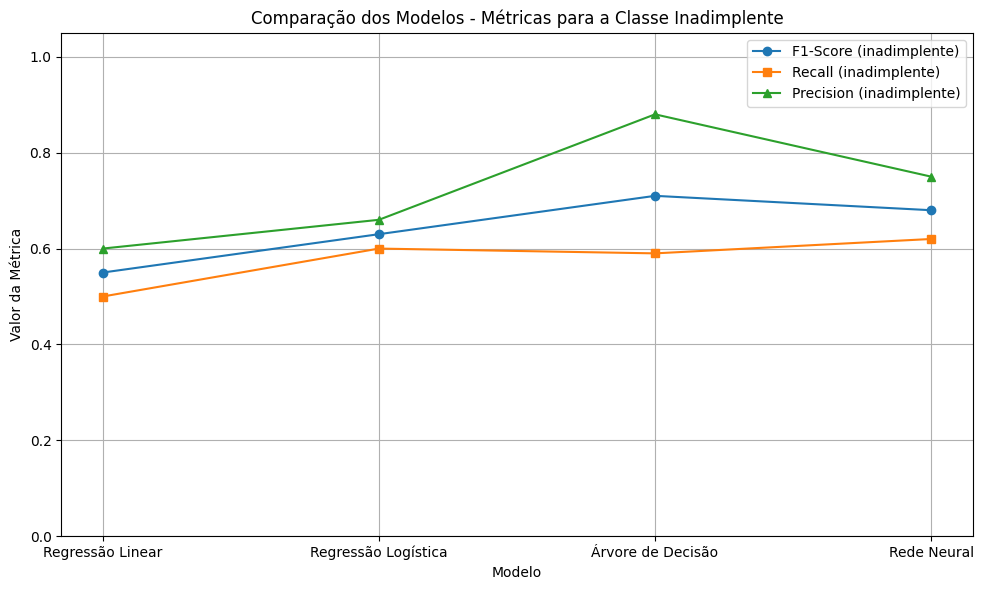

In [34]:
import matplotlib.pyplot as plt

# Substitua pelos valores reais dos seus modelos!
modelos = ["Regressão Linear", "Regressão Logística", "Árvore de Decisão", "Rede Neural"]
f1_inadimplente = [0.55, 0.63, 0.71, 0.68]
recall_inadimplente = [0.50, 0.60, 0.59, 0.62]
precision_inadimplente = [0.60, 0.66, 0.88, 0.75]

plt.figure(figsize=(10, 6))
plt.plot(modelos, f1_inadimplente, label="F1-Score (inadimplente)", marker='o')
plt.plot(modelos, recall_inadimplente, label="Recall (inadimplente)", marker='s')
plt.plot(modelos, precision_inadimplente, label="Precision (inadimplente)", marker='^')

plt.title("Comparação dos Modelos - Métricas para a Classe Inadimplente")
plt.xlabel("Modelo")
plt.ylabel("Valor da Métrica")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Os 3 modelos mostram resultados bem parecidos em relação a acurária, mas o objetivo dessa análise é melhorar o recall, nosso foco é prever quem nao pagará, 60% em média de previsão de futuros devedores dependendo do contexto pode ser bom, mas tambem significa que 40% nao foram identificados e não auxiliaria a administração ou sindico tomarem medidas proativas para coibir.

Novas features e talvez um balanceamento melhor nas classes com peso maior para os inadimplentes podem melhorar o resultado de treinamento nos modelos